<a href="https://colab.research.google.com/github/zsombor-haasz/computer-vision/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
!git clone https://github.com/facebookresearch/mae.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'mae' already exists and is not an empty directory.
fatal: destination path 'r3m' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/r3m
  Attempting uninstall: r3m
    Found existing installation: r3m 0.0.0
    Can't uninstall 'r3m'. No files were found to uninstall.
  Running setup.py develop for r3m


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset

import sys
import os
import gc
import matplotlib.pyplot as plt
import numpy as np
import tqdm

sys.path.append('./mae')
import models_mae

!nvidia-smi

Sun Dec  4 21:36:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    28W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on a GPU")
else:
    device = torch.device("cpu")
    print("Running on a CPU")

Running on a GPU


In [ ]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


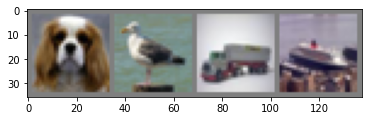

dog   bird  truck ship 


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        ### TODO ###
        """
        Make a convolutional architecture. Add convolutions (conv),
        pooling (pool), and fully connected layers (fc). For reference, you
        can use something like this:
              conv1 -> pool -> conv2 -> fc1 -> fc2 -> fc3
        Make sure the output and input are the right dimensions!
        """

        ### END TODO ###

    def forward(self, x):
        ### TODO ###
        """
        Implement the forward pass through the layers created in the init.
        Make sure to use activation functions after the conv and fc's
        Also, keep in mind the shape needed when switching from conv to fc
        Don't activate the last output!
        """
        ### END TODO ###
        return x

convnet = ConvNet().to(device)

In [ ]:
### TODO ###
"""
Fill criterion with the loss we want to use
Fill optimizer with an optimzer for the `convnet`
"""
criterion =
optimizer =
### END TODO ###

SyntaxError: ignored

In [ ]:
for epoch in range(5):
    running_loss = 0.0
    for inputs, labels in tqdm.notebook.tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        ### TODO ###
        """ Fill in the core training loop logic """
        # Zero out the optimizer

        # Get the network output

        # Find the loss

        # Backpropagate

        # Update parameters with the optimizer

        ### END TODO ###

        running_loss += loss.item()
    print(f'[{epoch + 1}] loss: {running_loss / (len(trainset) / batch_size):.3f}')
    running_loss = 0.0

print('Finished Training')

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        ### TODO ###
        """
        Loop through the data and compare the max prob predictions
        with the ground truth. Use this to find an accuracy.
        Hint: count correct and total!
        """
        ### END TODO ###

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# Pre-compute MoCo and MAE representations

In [ ]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(224),
                transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                     std=(0.229, 0.224, 0.225))
            ])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
def compute_embeddings_from_dataset(dataset, model, embedding_dim, device, batch_size):
    model.to(device=device)
    model = model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    embeddings = torch.zeros(len(dataset), embedding_dim)
    labels = torch.zeros(len(dataset))
    with torch.no_grad():
        for idx, batch in enumerate(tqdm.notebook.tqdm(dataloader)):
            start = idx * batch_size
            end = min((idx + 1) * batch_size, len(dataset))

            inputs, targets = batch
            embs = model(inputs.to(device))
            embeddings[start:end] = embs
            labels[start:end] = targets
    return embeddings, labels

In [ ]:
def prepare_moco(moco_state_dict):
    moco = models.resnet50(weights=None, progress=False)
    # rename moco pre-trained keys
    for k in list(moco_state_dict.keys()):
        # retain only encoder_q up to before the embedding layer
        if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
            # remove prefix
            moco_state_dict[k[len("module.encoder_q."):]] = moco_state_dict[k]
        # delete renamed or unused k
        del moco_state_dict[k]

    msg = moco.load_state_dict(moco_state_dict, strict=False)
    assert set(msg.missing_keys) == {"fc.weight", "fc.bias"}
    moco.fc = nn.Identity()

    for param in moco.parameters():
        param.requires_grad = False

    return moco
! curl -OL https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar
checkpoint_moco = torch.load("/content/moco_v2_800ep_pretrain.pth.tar", map_location=torch.device('cpu'))
moco_model = prepare_moco(checkpoint_moco["state_dict"])
print('MoCo model loaded.')

In [ ]:
moco_train_embeddings, moco_train_labels = compute_embeddings_from_dataset(trainset, moco_model, 2048, device, batch_size)
moco_test_embeddings, moco_test_labels = compute_embeddings_from_dataset(testset, moco_model, 2048, device, batch_size)

In [ ]:
class MAE_embedding_model(nn.Module):
    def __init__(self, checkpoint_path, arch='mae_vit_base_patch16'):
        super().__init__()
        # build model
        model = getattr(models_mae, arch)()
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint['model'], strict=False)
        self.mae = model
        for param in self.mae.parameters():
            param.requires_grad = False

    def forward(self, imgs, mask_ratio=0.0):
        latent, _, _ = self.mae.forward_encoder(imgs, mask_ratio)
        cls_latent = latent[:, 0, :]
        return cls_latent
! curl -OL https://dl.fbaipublicfiles.com/mae/pretrain/mae_pretrain_vit_base.pth
checkpoint_mae = '/content/mae_pretrain_vit_base.pth'
mae_model = MAE_embedding_model(checkpoint_mae)
print('MAE model loaded.')

In [ ]:
mae_train_embeddings, mae_train_labels = compute_embeddings_from_dataset(trainset, mae_model, 768, device, batch_size)
mae_test_embeddings, mae_test_labels = compute_embeddings_from_dataset(testset, mae_model, 768, device, batch_size)

# 1. Linear Classifier

In [ ]:
### TODO
""" Finish this model's class"""
class LinearProbe(nn.Module):
    def __init__(self, num_classes, embedding_dim):
        super().__init__()
        # Construct a linear layer
        self.fc1 = nn.Linear(embedding_dim, 10)

    def forward(self, x):
        # Pass through the linear layer
        return self.fc1(x)
### END TODO ###

In [ ]:
class FrozenEmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
        assert len(self.embeddings) == len(self.labels)
        self.length = len(self.embeddings)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [ ]:
def compute_accuracy(dataloader, probe):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            inputs, targets = data
            inputs, targets = inputs.to(device).float(), targets.to(device).long()
            # calculate outputs by running images through the network
            out = probe(inputs)
            # the class with the highest energy is what we choose as our prediction
            _, predicted = torch.max(out.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return 100.0 * correct / total

In [ ]:
batch_size = 256

In [ ]:
moco_probe = LinearProbe(len(classes), 2048).to(device=device)

trainset = FrozenEmbeddingDataset(moco_train_embeddings, moco_train_labels)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = FrozenEmbeddingDataset(moco_test_embeddings, moco_test_labels)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

### TODO ###
"""
Fill criterion with the loss we want to use
Fill optimizer with an optimzer for the `convnet`
"""
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(moco_probe.parameters(), 0.0001)
### END TODO ###

In [ ]:
for epoch in range(80):
    train_loss = 0.0
    for inputs, labels in tqdm.notebook.tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        ### TODO ###
        """ Fill in the core training loop logic """
        # Zero out the optimizer
        optimizer.zero_grad()

        # Get the network output
        outputs = moco_probe(inputs)

        # Find the loss
        loss = criterion(outputs, labels)

        # Backpropagate
        loss.backward()

        # Update parameters with the optimizer
        optimizer.step()

        ### END TODO ###

        train_loss += loss.item()

    test_loss = 0.0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = moco_probe(images)
            loss = criterion(outputs, labels.long())

            test_loss += loss.item()

    print(f'[{epoch + 1}] train loss: {train_loss / (len(trainset) / batch_size):.3f} | test_loss: {test_loss / (len(testset) / batch_size):.3f}')

print('Finished Training')

In [ ]:
tmmoco_accuracy = compute_accuracy(testloader, moco_probe)
print(f'Accuracy of the network on the 10000 test images: {moco_accuracy} %')

In [ ]:
mae_probe = LinearProbe(len(classes), 768).to(device=device)

trainset = FrozenEmbeddingDataset(mae_train_embeddings, mae_train_labels)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = FrozenEmbeddingDataset(mae_test_embeddings, mae_test_labels)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

### TODO ###
"""
Fill criterion with the loss we want to use
Fill optimizer with an optimzer for the `convnet`
"""
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(moco_probe.parameters(), 0.0001)
### END TODO ###

In [ ]:
for epoch in range(80):
    train_loss = 0.0
    for inputs, labels in tqdm.notebook.tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        ### TODO ###
        """ Fill in the core training loop logic """
        # Zero out the optimizer
        optimizer.zero_grad()

        # Get the network output
        output = mae_probe(inputs)

        # Find the loss
        loss = criterion(inputs, labels)

        # Backpropagate
        loss.backward()

        # Update parameters with the optimizer
        optimizer.step()

        ### END TODO ###

        train_loss += loss.item()

    test_loss = 0.0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = mae_probe(images)
            loss = criterion(outputs, labels.long())

            test_loss += loss.item()

    print(f'[{epoch + 1}] train loss: {train_loss / (len(trainset) / batch_size):.3f} | test_loss: {test_loss / (len(testset) / batch_size):.3f}')

print('Finished Training')

In [ ]:
moco_accuracy = compute_accuracy(testloader, mae_probe)
print(f'Accuracy of the network on the 10000 test images: {moco_accuracy} %')

# 2. K-Nearest Neighbors (Evaluate with a KNN classifier instead of a linear probe)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_moco = KNeighborsClassifier()
""" Fit the KNN to the embeddings from moco and the labels provided """
knn_moco.fit(moco_train_embeddings, moco_train_labels)

In [ ]:
""" Get the predictions and accuracy on the test set """
predictions = knn_moco.predict(moco_test_embeddings.numpy())
accuracy = (predictions == moco_test_labels.numpy()).mean() * 100
print(accuracy)

In [ ]:
knn_mae = KNeighborsClassifier()
""" Fit the KNN to the embeddings from moco and the labels provided """
knn_mae.fit(mae_train_embeddings.numpy(), mae_train_labels.numpy())

In [ ]:
""" Get the predictions and accuracy on the test set """
predictions = knn_mae.predict(mae_test_embeddings.numpy())
accuracy = (predictions == mae_test_labels.numpy()).mean() * 100
print(accuracy)

# Visualizations

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
import seaborn as sns

In [ ]:
# First reduce the dimension of Moco embeddings via PCA to 128 dimensions
moco_pca = PCA(n_components=128).fit_transform(moco_train_embeddings)
# Then make `moco_embedded` which is a TSNE projection with 2 comonents from the PCA output
moco_embedded = TSNE(n_components=2, perplexity=50, learning_rate='auto', init='random').fit_transform(moco_pca)

moco_class_labels = np.take(np.array(classes), moco_train_labels.int())
sns.scatterplot(x=moco_embedded[:, 0], y=moco_embedded[:, 1], hue=moco_class_labels)

In [ ]:
# First reduce the dimension of MAE embeddings via PCA to 128 dimensions
mae_pca = PCA(n_components=128).fit_transform(mae_train_embeddings)
# Then make `mae_embedded` which is a TSNE projection with 2 comonents from the PCA output
mae_embedded = TSNE(n_components=2, perplexity=50, learning_rate='auto', init='random').fit_transform(mae_pca)

mae_class_labels = np.take(np.array(classes), mae_train_labels.int())
sns.scatterplot(x=mae_embedded[:, 0], y=mae_embedded[:, 1], hue=mae_class_labels)